# Import Statements

In [1]:
import os
os.chdir('../../geodata')
import logging
logging.basicConfig(level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

import geodata
import xarray as xr
import pandas as pd
import numpy as np
import pickle

from shapely.geometry import shape
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import statsmodels.api as sm
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Load from pickle

In [2]:
os.chdir('../india_RE_transition/data/pickle')

# district data
file = open("districts.pickle",'rb')
districts = pickle.load(file)
file.close()
# state shapes
file = open("states.pickle",'rb')
states = pickle.load(file)
file.close()
# grid state shapes
file = open("grid_states.pickle",'rb')
grid_states = pickle.load(file)
file.close()
# ranked district data
file = open("JPCD_sum.pickle",'rb')
JPCD_sum = pickle.load(file)
file.close()
# includes LCOE
file = open("xarray_ds_wind.pickle",'rb')
xarray_ds_wind = pickle.load(file)
file.close()
file = open("xarray_ds_solar.pickle",'rb')
xarray_ds_solar = pickle.load(file)
file.close()
# renewable energy targets
# TERI
file = open("wind_t_30.pickle",'rb')
wind_t_30 = pickle.load(file)
file.close()
file = open("solar_t_30.pickle",'rb')
solar_t_30 = pickle.load(file)
file.close()
# NREL
file = open("wind_t_47.pickle",'rb')
wind_t_47 = pickle.load(file)
file.close()
file = open("solar_t_47.pickle",'rb')
solar_t_47 = pickle.load(file)
file.close()
file = open("grid_wind_t_30.pickle",'rb')
grid_wind_t_30 = pickle.load(file)
file.close()
file = open("grid_solar_t_30.pickle",'rb')
grid_solar_t_30 = pickle.load(file)
file.close()
# NREL
file = open("grid_wind_t_47.pickle",'rb')
grid_wind_t_47 = pickle.load(file)
file.close()
file = open("grid_solar_t_47.pickle",'rb')
grid_solar_t_47 = pickle.load(file)
file.close()
#Legends
file = open("grid_legend.pickle",'rb')
grid_legend = pickle.load(file)
file.close()
file = open("state_legend.pickle",'rb')
state_legend = pickle.load(file)
file.close()
# coal incumbency states and districts
file = open("high.pickle",'rb')
high = pickle.load(file)
file.close()
file = open("high_districts.pickle",'rb')
high_districts = pickle.load(file)
file.close()
file = open("high_states.pickle",'rb')
high_states = pickle.load(file)
file.close()
file = open("mid.pickle",'rb')
mid = pickle.load(file)
file.close()
file = open("mid_districts.pickle",'rb')
mid_districts = pickle.load(file)
file.close()
file = open("mid_states.pickle",'rb')
mid_states = pickle.load(file)
file.close()
file = open("low.pickle",'rb')
low = pickle.load(file)
file.close()
file = open("low_districts.pickle",'rb')
low_districts = pickle.load(file)
file.close()
file = open("low_states.pickle",'rb')
low_states = pickle.load(file)
file.close()
#combined with cutout
file = open("combine_wind_high.pickle",'rb')
combine_wind_high = pickle.load(file)
file.close()
file = open("combine_wind_mid.pickle",'rb')
combine_wind_mid = pickle.load(file)
file.close()
file = open("combine_wind_low.pickle",'rb')
combine_wind_low = pickle.load(file)
file.close()
file = open("combine_solar_high.pickle",'rb')
combine_solar_high = pickle.load(file)
file.close()
file = open("combine_solar_mid.pickle",'rb')
combine_solar_mid = pickle.load(file)
file.close()
file = open("combine_solar_low.pickle",'rb')
combine_solar_low = pickle.load(file)
file.close()
# state heatmap data
file = open("wind_cf_summary_30.pickle",'rb')
wind_cf_summary_30 = pickle.load(file)
file.close()
file = open("wind_lcoe_summary_30.pickle",'rb')
wind_lcoe_summary_30 = pickle.load(file)
file.close()
file = open("solar_cf_summary_30.pickle",'rb')
solar_cf_summary_30 = pickle.load(file)
file.close()
file = open("solar_lcoe_summary_30.pickle",'rb')
solar_lcoe_summary_30 = pickle.load(file)
file.close()
file = open("wind_cf_summary_47.pickle",'rb')
wind_cf_summary_47 = pickle.load(file)
file.close()
file = open("wind_lcoe_summary_47.pickle",'rb')
wind_lcoe_summary_47 = pickle.load(file)
file.close()
file = open("solar_cf_summary_47.pickle",'rb')
solar_cf_summary_47 = pickle.load(file)
file.close()
file = open("solar_lcoe_summary_47.pickle",'rb')
solar_lcoe_summary_47 = pickle.load(file)
file.close()
# grid heatmap data
file = open("grid_wind_cf_summary_30.pickle",'rb')
grid_wind_cf_summary_30 = pickle.load(file)
file.close()
file = open("grid_wind_lcoe_summary_30.pickle",'rb')
grid_wind_lcoe_summary_30 = pickle.load(file)
file.close()
file = open("grid_solar_cf_summary_30.pickle",'rb')
grid_solar_cf_summary_30 = pickle.load(file)
file.close()
file = open("grid_solar_lcoe_summary_30.pickle",'rb')
grid_solar_lcoe_summary_30 = pickle.load(file)
file.close()
file = open("grid_wind_cf_summary_47.pickle",'rb')
grid_wind_cf_summary_47 = pickle.load(file)
file.close()
file = open("grid_wind_lcoe_summary_47.pickle",'rb')
grid_wind_lcoe_summary_47 = pickle.load(file)
file.close()
file = open("grid_solar_cf_summary_47.pickle",'rb')
grid_solar_cf_summary_47 = pickle.load(file)
file.close()
file = open("grid_solar_lcoe_summary_47.pickle",'rb')
grid_solar_lcoe_summary_47 = pickle.load(file)
file.close()

os.chdir('../..')

# Download India 2018 ERA5 Hourly Weather Data

In [14]:
DS_hourly = geodata.Dataset(module="era5",
                            weather_data_config = "wind_solar_hourly",
                            bounds=[37, 68, 6, 98],
                            years=slice(2018, 2018),
                            months=slice(1,12))

if DS_hourly.prepared == False:
	DS_hourly.get_data()

INFO:geodata.dataset:Directory C:/Users/arjun/desktop/davidson_lab/data/era5 found, checking for completeness.
INFO:geodata.dataset:Directory complete.


# Create Cutout

In [15]:
## CUTOUT
cutout = geodata.Cutout(name = "india-2018-era5-wind-solar-hourly",
                        module = "era5",
                        weather_data_config = "wind_solar_hourly",
                        xs = slice(68, 98),
                        ys = slice(6, 37),
                        years=slice(2018, 2018),
                        months=slice(1,12))

cutout.prepare()

INFO:geodata.cutout:All cutout (india-2018-era5-wind-solar-hourly, C:/Users/arjun/desktop/davidson_lab/data/cutouts) files available.
INFO:geodata.cutout:Cutout subset prepared: <Cutout india-2018-era5-wind-solar-hourly x=68.00-98.00 y=37.00-6.00 time=2018/1-2018/12 prepared>
INFO:geodata.preparation:The cutout is already prepared. If you want to recalculate it, supply an `overwrite=True` argument.


True

# Get Wind & Solar Profiles

In [ ]:
ds_wind = geodata.convert.wind(cutout, 
                               turbine='Siemens_SWT_107_3600kW')

ds_solar = geodata.convert.pv(cutout,
                              panel = "KANENA",
                              orientation = "latitude_optimal")

# Plot cutout for sanity check

In [ ]:
ds_wind = ds_wind.reset_coords(['lon', 'lat'], drop = True).rename({'x': 'lon', 'y': 'lat'})
ds_solar = ds_solar.reset_coords(['lon', 'lat'], drop = True).rename({'x': 'lon', 'y': 'lat'})

ds_wind.sortby(['lon', 'lat'])
ds_solar.sortby(['lon', 'lat'])

xarray_ds_wind = ds_wind.to_dataset(name = 'wind')
xarray_ds_solar = ds_solar.to_dataset(name = 'solar')

xarray_ds_wind = xarray_ds_wind.coarsen(time = 8760, boundary = 'exact').mean()
xarray_ds_solar = xarray_ds_solar.coarsen(time = 8760, boundary = 'exact').mean()

## Rank Districts by "Coal Incumbency"

### Calculate cdfs

In [ ]:
jobs_cdf = sm.distributions.ECDF(districts['Coal Job %'].dropna())
pensions_cdf = sm.distributions.ECDF(districts['Coal Pensioners %'].dropna())
dmf_cdf = sm.distributions.ECDF(districts[districts['DMF USD'] > 0]['DMF USD'].dropna())
csr_cdf = sm.distributions.ECDF(districts[districts['CSR USD'] > 0]['CSR USD'].dropna())

In [ ]:
# plt.step(jobs_cdf.x, jobs_cdf.y)
# plt.show()
# plt.step(pensions_cdf.x, pensions_cdf.y)
# plt.show()
# plt.step(dmf_cdf.x, dmf_cdf.y)
# plt.show()
# plt.step(csr_cdf.x, csr_cdf.y)
# plt.show()

In [ ]:
def return_edges(cdf):
    bin_edges = []
    bin_edges.append(cdf.x[0])

    for lst in np.array_split(cdf.x, 3):
        bin_edges.append(lst[len(lst) - 1])
        
    return bin_edges

def return_groups(val, bin_edges):
    if val == 0:
        return 0
    elif val >= bin_edges[2] and val <= bin_edges[3]:
        return 3
    elif val >= bin_edges[1] and val <= bin_edges[2]:
        return 2
    elif val >= bin_edges[0] and val <= bin_edges[1]:
        return 1
    else:
        return None

In [ ]:
# Bins
jobs_edges = return_edges(jobs_cdf)
pensions_edges = return_edges(pensions_cdf)
dmf_edges = return_edges(csr_cdf)
csr_edges = return_edges(dmf_cdf)

# Assign labels to equal percentile groups 
job_groups = districts['Coal Job %'].apply(lambda x: return_groups(x, jobs_edges))
pension_groups = districts['Coal Pensioners %'].apply(lambda x: return_groups(x, pensions_edges))
csr_groups = districts['CSR USD'].apply(lambda x: return_groups(x, csr_edges))
dmf_groups = districts['DMF USD'].apply(lambda x: return_groups(x, dmf_edges))

# Create new columns 
JPCD_sum = districts.assign(
    J = job_groups, 
    P = pension_groups, 
    C = csr_groups,
    D = dmf_groups
)
JPCD_sum = JPCD_sum[['State Name', 'District Name', 'Geometry', 'J', 'P', 'C', 'D']]

# Prepare for weighted sum 
JPCD_sum['J'] = JPCD_sum['J'].apply(lambda x: x*1)
JPCD_sum['P'] = JPCD_sum['P'].apply(lambda x: x*1/2)
JPCD_sum['C'] = JPCD_sum['C'].apply(lambda x: x*1/3)
JPCD_sum['D'] = JPCD_sum['D'].apply(lambda x: x*1/4)

# Create Rank Score by summing
JPCD_sum['Score'] = JPCD_sum[['J', 'P', 'D', 'C']].sum(axis = 1)
scores_cdf = sm.distributions.ECDF(JPCD_sum[JPCD_sum['Score'] > 0]['Score'])
scores_edges = return_edges(scores_cdf)
JPCD_sum['Rank'] = JPCD_sum['Score'].apply(lambda x: return_groups(x, scores_edges))
JPCD_sum

In [ ]:
# export to pickle
os.chdir('data/pickle')
filehandler = open("JPCD_sum.pickle","wb")
pickle.dump(JPCD_sum, filehandler)
filehandler.close()

### High Coal Incumbency Districts

In [ ]:
high = JPCD_sum[JPCD_sum['Rank'] == 3]
high_states = np.unique(high['State Name'])
high_districts = cascaded_union(high['Geometry'])

In [ ]:
# export to pickle
filehandler = open("high.pickle","wb")
pickle.dump(high, filehandler)
filehandler.close()
filehandler = open("high_districts.pickle","wb")
pickle.dump(high_districts, filehandler)
filehandler.close()
filehandler = open("high_states.pickle","wb")
pickle.dump(high_states, filehandler)
filehandler.close()

### Mid Coal Incumbency Districts

In [ ]:
mid = JPCD_sum[JPCD_sum['Rank'].isin([2,1])]
mid_states = np.unique(mid['State Name'])
mid_districts = cascaded_union(mid['Geometry'])

In [ ]:
# export to pickle
filehandler = open("mid.pickle","wb")
pickle.dump(mid, filehandler)
filehandler.close()
filehandler = open("mid_districts.pickle","wb")
pickle.dump(mid_districts, filehandler)
filehandler.close()
filehandler = open("mid_states.pickle","wb")
pickle.dump(mid_states, filehandler)
filehandler.close()

### Low Coal Incumbency Districts

In [ ]:
low = JPCD_sum[JPCD_sum['Rank'] == 0]
low_states = np.unique(low['State Name'])
low_districts = cascaded_union(low['Geometry'])

In [ ]:
# export to pickle
filehandler = open("low.pickle","wb")
pickle.dump(low, filehandler)
filehandler.close()
filehandler = open("low_districts.pickle","wb")
pickle.dump(low_districts, filehandler)
filehandler.close()
filehandler = open("low_states.pickle","wb")
pickle.dump(low_states, filehandler)
filehandler.close()

# Transmission / Substation Data

In [ ]:
transmission = gpd.read_file('cae13821b4b7807f792aa0c03e0fd75903dae11dbd363484b1376ab9.shp')
transmission = transmission.drop(columns=['name']).reset_index()
transmission = gpd.GeoDataFrame(transmission, geometry='geometry')
transmission.to_file("transmission.shp", driver='ESRI Shapefile')

In [ ]:
substations = transmission.geometry.apply(lambda x: Point(x.bounds[:2], x.bounds[2:])).explode().reset_index()
substations = substations.drop(columns=['level_1'])
substations.columns = ['index', 'geometry']
substations = gpd.GeoDataFrame(substations, geometry='geometry')
substations.to_file("substations.shp", driver='ESRI Shapefile')

In [ ]:
grid_cells = pd.DataFrame(cutout.grid_cells()).reset_index()
grid_cells.columns = ['index', 'geometry']
grid_cells = gpd.GeoDataFrame(grid_cells, geometry='geometry')
grid_cells.to_file("grid_cells.shp", driver='ESRI Shapefile')

### Calculate Distances using QGIS
- https://www.qgistutorials.com/en/docs/3/nearest_neighbor_analysis.html

In [ ]:
os.chdir('../tables')
transmission = pd.read_csv('trans_distances.csv')
transmission = pd.DataFrame(cutout.grid_coordinates()).join(transmission).drop(columns=['index', 'HubName'])
transmission.columns = ['lon', 'lat', 'Closest Transmission Line Distance (km)']
transmission = transmission.set_index(['lon', 'lat'])
transmission

In [ ]:
substation = pd.read_csv('substation_distance.csv')
substation = pd.DataFrame(cutout.grid_coordinates()).join(substation).drop(columns=['index', 'HubName'])
substation.columns = ['lon', 'lat', 'Closest Substation Distance (km)']
substation = substation.set_index(['lon', 'lat'])
substation

# LCOE Calculation

In [ ]:
df_ds_wind = xarray_ds_wind.to_dataframe().reset_index().set_index(['lon', 'lat'])
df_ds_wind['transmission_distance'] = transmission['Closest Transmission Line Distance (km)']
df_ds_wind['substation_distance'] = substation['Closest Substation Distance (km)']
df_ds_wind = df_ds_wind[df_ds_wind['wind'] > 0.05]
df_ds_wind['LCOE ($/MWh)'] = (0.104 * (1250 + df_ds_wind['substation_distance'] * 0.45) + 15) * 1000 / (df_ds_wind['wind'] * 8760)
xarray_ds_wind = df_ds_wind.reset_index().set_index(['time', 'lat', 'lon']).to_xarray()

df_ds_solar = xarray_ds_solar.to_dataframe().reset_index().set_index(['lon', 'lat'])
df_ds_solar['transmission_distance'] = transmission['Closest Transmission Line Distance (km)']
df_ds_solar['substation_distance'] = substation['Closest Substation Distance (km)']
df_ds_solar['LCOE ($/MWh)'] = (0.096 * (850 + df_ds_solar['substation_distance'] * 0.45) + 10) * 1000 / (df_ds_solar['solar'] * 8760)
xarray_ds_solar = df_ds_solar.reset_index().set_index(['time', 'lat', 'lon']).to_xarray()

In [ ]:
# xarray_ds_wind['wind'].plot()
# xarray_ds_wind['LCOE ($/MWh)'].plot()
# xarray_ds_solar['solar'].plot()
# xarray_ds_solar['LCOE ($/MWh)'].plot()

In [ ]:
os.chdir('../pickle')
# export to pickle
filehandler = open("xarray_ds_wind.pickle","wb")
pickle.dump(xarray_ds_wind, filehandler)
filehandler.close()
filehandler = open("xarray_ds_solar.pickle","wb")
pickle.dump(xarray_ds_solar, filehandler)
filehandler.close()

# Load Geodata MODIS Mask

In [5]:
# os.chdir('../masks')

In [6]:
india_wind_high = geodata.Mask("India Wind High", layer_path = {
    'suitability': 'MODIS_INDIA_WIND.tif'
})
india_wind_mid = geodata.Mask("India Wind Mid", layer_path = {
    'suitability': 'MODIS_INDIA_WIND.tif'
})
india_wind_low = geodata.Mask("India Wind Low", layer_path = {
    'suitability': 'MODIS_INDIA_WIND.tif'
})

india_solar_high = geodata.Mask("India Solar High", layer_path = {
    'suitability': 'MODIS_INDIA_SOLAR.tif'
})
india_solar_mid = geodata.Mask("India Solar Mid", layer_path = {
    'suitability': 'MODIS_INDIA_SOLAR.tif'
})
india_solar_low = geodata.Mask("India Solar Low", layer_path = {
    'suitability': 'MODIS_INDIA_SOLAR.tif'
})

INFO:geodata.mask:Layer suitability added to the mask India Wind High.
INFO:geodata.mask:Layer suitability added to the mask India Wind Mid.
INFO:geodata.mask:Layer suitability added to the mask India Wind Low.
INFO:geodata.mask:Layer suitability added to the mask India Solar High.
INFO:geodata.mask:Layer suitability added to the mask India Solar Mid.
INFO:geodata.mask:Layer suitability added to the mask India Solar Low.


In [ ]:
# india_wind_high.layers['suitability'] = geodata.mask.binarize_raster(india_wind_high.layers['suitability'], values = [6,7,8,9,10,12,14,16])
# india_wind_mid.layers['suitability'] = geodata.mask.binarize_raster(india_wind_mid.layers['suitability'], values = [6,7,8,9,10,12,14,16])
# india_wind_low.layers['suitability'] = geodata.mask.binarize_raster(india_wind_low.layers['suitability'], values = [6,7,8,9,10,12,14,16])
# india_wind_all.layers['suitability'] = geodata.mask.binarize_raster(india_wind_all.layers['suitability'], values = [6,7,8,9,10,12,14,16])

# india_solar_high.layers['suitability'] = geodata.mask.binarize_raster(india_solar_high.layers['suitability'], values = [6,7,8,9,10,16])
# india_solar_mid.layers['suitability'] = geodata.mask.binarize_raster(india_solar_mid.layers['suitability'], values = [6,7,8,9,10,16])
# india_solar_low.layers['suitability'] = geodata.mask.binarize_raster(india_solar_low.layers['suitability'], values = [6,7,8,9,10,16])
# india_solar_all.layers['suitability'] = geodata.mask.binarize_raster(india_solar_all.layers['suitability'], values = [6,7,8,9,10,16])

In [ ]:
# geodata.mask.show_all(india_solar_high.layers)
# geodata.mask.show_all(india_wind_high.layers)

# Extract District Shapes as Mask Layers

## Districts by coal incumbency

In [7]:
high_districts = {'districts': high_districts}
mid_districts = {'districts': mid_districts}
low_districts = {'districts': low_districts}

In [8]:
india_wind_high.extract_shapes(high_districts, layer = 'suitability')
india_wind_mid.extract_shapes(mid_districts, layer = 'suitability')
india_wind_low.extract_shapes(low_districts, layer = 'suitability')

india_solar_high.extract_shapes(high_districts, layer = 'suitability')
india_solar_mid.extract_shapes(mid_districts, layer = 'suitability')
india_solar_low.extract_shapes(low_districts, layer = 'suitability')

INFO:geodata.mask:Extracted shape districts added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape districts added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape districts added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape districts added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape districts added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape districts added to attribute 'shape_mask'.


In [9]:
india_wind_high.add_shape_layer({
    'districts': high_districts['districts']
}, reference_layer='suitability')

india_wind_mid.add_shape_layer({
    'districts': mid_districts['districts'],
}, reference_layer='suitability')

india_wind_low.add_shape_layer({
    'districts': low_districts['districts'],
}, reference_layer='suitability')

india_solar_high.add_shape_layer({
    'districts': high_districts['districts'],
}, reference_layer='suitability')

india_solar_mid.add_shape_layer({
    'districts': mid_districts['districts'],
}, reference_layer='suitability')

india_solar_low.add_shape_layer({
    'districts': low_districts['districts'],
}, reference_layer='suitability')

INFO:geodata.mask:Layer districts added to the mask India Wind High.
INFO:geodata.mask:Layer districts added to the mask India Wind Mid.
INFO:geodata.mask:Layer districts added to the mask India Wind Low.
INFO:geodata.mask:Layer districts added to the mask India Solar High.
INFO:geodata.mask:Layer districts added to the mask India Solar Mid.
INFO:geodata.mask:Layer districts added to the mask India Solar Low.


# Merge Districts + MODIS

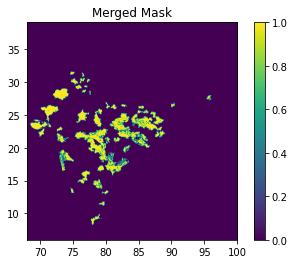

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


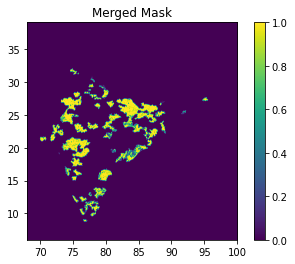

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


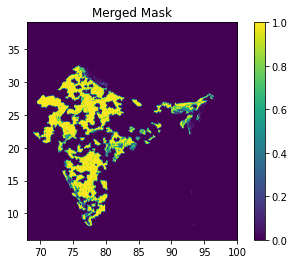

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


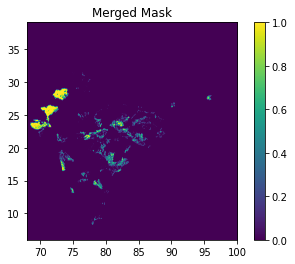

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


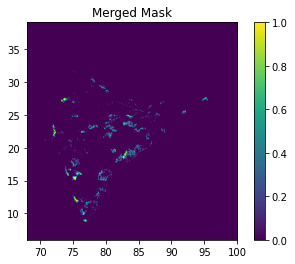

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


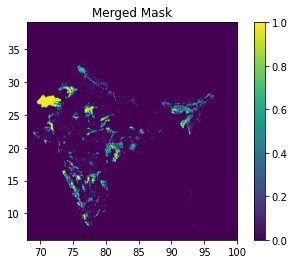

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [10]:
india_wind_high.merge_layer(attribute_save = True, layers = ['suitability', 'districts'], method='and')
india_wind_mid.merge_layer(attribute_save = True, layers = ['suitability', 'districts'], method='and')
india_wind_low.merge_layer(attribute_save = True, layers = ['suitability', 'districts'], method='and')

india_solar_high.merge_layer(attribute_save = True, layers = ['suitability', 'districts'], method='and')
india_solar_mid.merge_layer(attribute_save = True, layers = ['suitability', 'districts'], method='and')
india_solar_low.merge_layer(attribute_save = True, layers = ['suitability', 'districts'], method='and')

## States 

In [ ]:
def shpreader_path(theme):
    '''
    Given a theme such as 'admin_1_states_provinces' or 'admin_0_countries', download the dbf/shp/shx data from 
    https://www.naturalearthdata.com/downloads/10m-cultural-vectors/;
    
    If the files have been successfully downloaded, return the path to these files that get_shapes() read;
    '''
    return shpreader.natural_earth(resolution='10m', category='cultural',
                                name = theme)

In [ ]:
country_path = shpreader_path('admin_0_countries')
prov_path = shpreader_path('admin_1_states_provinces')

states = geodata.mask.get_shape(prov_path, key = 'name_en', return_dict = True, condition_key = 'admin', 
                                condition_value = 'India')

os.chdir('../shapes')
# Include Telangana
india = gpd.read_file('gadm36_IND_1.shp')
india = india[india['NAME_1'] == 'Telangana']
states['Telangana'] = india['geometry'][31]

In [ ]:
# export to pickle
os.chdir('../pickle')
filehandler = open("states.pickle","wb")
pickle.dump(states, filehandler)
filehandler.close()

In [11]:
india_wind_high.extract_shapes({x: states[x] for x in high_states if x in states.keys()})
india_wind_mid.extract_shapes({x: states[x] for x in mid_states if x in states.keys()})
india_wind_low.extract_shapes({x: states[x] for x in low_states if x in states.keys()})

india_solar_high.extract_shapes({x: states[x] for x in high_states if x in states.keys()})
india_solar_mid.extract_shapes({x: states[x] for x in mid_states if x in states.keys()})
india_solar_low.extract_shapes({x: states[x] for x in low_states if x in states.keys()})

INFO:geodata.mask:Extracted shape Andhra Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Assam added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Bihar added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Chhattisgarh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Gujarat added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Haryana added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Jharkhand added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Karnataka added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Madhya Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Maharashtra added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Odisha added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Punjab added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Rajasthan added to attribute 'shape_mask'.
IN

INFO:geodata.mask:Extracted shape Andhra Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Arunachal Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Assam added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Bihar added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Chandigarh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Chhattisgarh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Delhi added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Goa added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Gujarat added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Haryana added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Himachal Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Jharkhand added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Karnataka added to attribute 'shape_mask

## Grid Regions

In [ ]:
regions = {
    "Northern": ["Chandigarh", "Delhi", "Haryana", "Himachal Pradesh", "Jammu and Kashmir", 
                 "Punjab", "Rajasthan", "Uttar Pradesh", "Uttarakhand"],
    "Eastern": ["Bihar", "Jharkhand", "Odisha", "West Bengal", "Sikkim", "Andaman and Nicobar Islands"],
    "Western": ["Chhattisgarh", "Gujarat", "Daman and Diu", "Dadra and Nagar Haveli",
                "Madhya Pradesh", "Maharashtra", "Goa"],
    "North-Eastern": ["Arunachal Pradesh", "Assam", "Manipur", "Meghalaya", "Mizoram", "Nagaland", "Tripura"],
    "Southern": ["Andhra Pradesh", "Telangana", "Karnataka", "Kerala", "Tamil Nadu", "Puducherry", "Lakshadweep"]
}

In [ ]:
northern_grid = JPCD_sum[JPCD_sum['State Name'].isin(regions['Northern'])]
northern_grid_districts = cascaded_union(northern_grid['Geometry'])

eastern_grid = JPCD_sum[JPCD_sum['State Name'].isin(regions['Eastern'])]
eastern_grid_districts = cascaded_union(eastern_grid['Geometry'])

western_grid = JPCD_sum[JPCD_sum['State Name'].isin(regions['Western'])]
western_grid_districts = cascaded_union(western_grid['Geometry'])

northeastern_grid = JPCD_sum[JPCD_sum['State Name'].isin(regions['North-Eastern'])]
northeastern_grid_districts = cascaded_union(northeastern_grid['Geometry'])

southern_grid = JPCD_sum[JPCD_sum['State Name'].isin(regions['Southern'])]
southern_grid_districts = cascaded_union(southern_grid['Geometry'])

In [ ]:
grid_states = {
    "Northern": northern_grid_districts,
    "Eastern": eastern_grid_districts,
    "Western": western_grid_districts,
    "North-Eastern": northeastern_grid_districts,
    "Southern": southern_grid_districts
}
grid_states

In [ ]:
# export to pickle
os.chdir('../pickle')
filehandler = open("grid_states.pickle","wb")
pickle.dump(grid_states, filehandler)
filehandler.close()

In [ ]:
india_wind_high.extract_shapes({x: grid_states[x] for x in grid_states})
india_wind_mid.extract_shapes({x: grid_states[x] for x in grid_states})
india_wind_low.extract_shapes({x: grid_states[x] for x in grid_states})

india_solar_high.extract_shapes({x: grid_states[x] for x in grid_states})
india_solar_mid.extract_shapes({x: grid_states[x] for x in grid_states})
india_solar_low.extract_shapes({x: grid_states[x] for x in grid_states})

# Renewable Targets

## 2030 State Targets
TERI

### Total Wind

In [ ]:
sum(wind_t_30.values())

###  Total Solar

In [ ]:
sum(solar_t_30.values())

###  Total Wind + Solar

In [ ]:
sum(solar_t_30.values()) + sum(wind_t_30.values())

## 2030 Grid Targets

In [ ]:
grid_wind_t_30 = {
    "Northern": sum([wind_t_30[x] for x in regions["Northern"] if x in wind_t_30.keys()]),
    "Eastern": sum([wind_t_30[x] for x in regions["Eastern"] if x in wind_t_30.keys()]),
    "Western": sum([wind_t_30[x] for x in regions["Western"] if x in wind_t_30.keys()]),
    "North-Eastern": sum([wind_t_30[x] for x in regions["North-Eastern"] if x in wind_t_30.keys()]),
    "Southern": sum([wind_t_30[x] for x in regions["Southern"] if x in wind_t_30.keys()])
}

In [ ]:
sum(grid_wind_t_30.values())

In [ ]:
grid_solar_t_30 = {
    "Northern": sum([solar_t_30[x] for x in regions["Northern"] if x in solar_t_30.keys()]),
    "Eastern": sum([solar_t_30[x] for x in regions["Eastern"] if x in solar_t_30.keys()]),
    "Western": sum([solar_t_30[x] for x in regions["Western"] if x in solar_t_30.keys()]),
    "North-Eastern": sum([solar_t_30[x] for x in regions["North-Eastern"] if x in solar_t_30.keys()]),
    "Southern": sum([solar_t_30[x] for x in regions["Southern"] if x in solar_t_30.keys()])
}

In [ ]:
grid_solar_t_30

In [ ]:
sum(grid_solar_t_30.values())

## 2047 State Targets: 
NREL~Least-Cost Pathways for India’s Electric Power Sector-2020.pdf
- 575 GW - solar
- 445 GW -  wind

### Total Wind

In [ ]:
sum(wind_t_47.values())

###  Total Solar

In [ ]:
sum(solar_t_47.values())

###  Total Wind + Solar

In [ ]:
sum(wind_t_47.values()) + sum(solar_t_47.values())

## 2047 Grid Targets

In [ ]:
grid_wind_t_47 = {
    "Northern": sum([wind_t_47[x] for x in regions["Northern"] if x in wind_t_47.keys()]),
    "Eastern": sum([wind_t_47[x] for x in regions["Eastern"] if x in wind_t_47.keys()]),
    "Western": sum([wind_t_47[x] for x in regions["Western"] if x in wind_t_47.keys()]),
    "North-Eastern": sum([wind_t_47[x] for x in regions["North-Eastern"] if x in wind_t_47.keys()]),
    "Southern": sum([wind_t_47[x] for x in regions["Southern"] if x in wind_t_47.keys()])
}

In [ ]:
sum(grid_wind_t_47.values())

In [ ]:
grid_solar_t_47 = {
    "Northern": sum([solar_t_47[x] for x in regions["Northern"] if x in solar_t_47.keys()]),
    "Eastern": sum([solar_t_47[x] for x in regions["Eastern"] if x in solar_t_47.keys()]),
    "Western": sum([solar_t_47[x] for x in regions["Western"] if x in solar_t_47.keys()]),
    "North-Eastern": sum([solar_t_47[x] for x in regions["North-Eastern"] if x in solar_t_47.keys()]),
    "Southern": sum([solar_t_47[x] for x in regions["Southern"] if x in solar_t_47.keys()])
}

In [ ]:
grid_solar_t_30

In [ ]:
sum(grid_solar_t_47.values())

In [ ]:
# export to pickle
filehandler = open("wind_t_30.pickle","wb")
pickle.dump(wind_t_30, filehandler)
filehandler.close()
filehandler = open("solar_t_30.pickle","wb")
pickle.dump(solar_t_30, filehandler)
filehandler.close()
filehandler = open("wind_t_47.pickle","wb")
pickle.dump(wind_t_47, filehandler)
filehandler.close()
filehandler = open("solar_t_47.pickle","wb")
pickle.dump(solar_t_47, filehandler)
filehandler.close()

filehandler = open("grid_wind_t_30.pickle","wb")
pickle.dump(grid_wind_t_30, filehandler)
filehandler.close()
filehandler = open("grid_solar_t_30.pickle","wb")
pickle.dump(grid_solar_t_30, filehandler)
filehandler.close()
filehandler = open("grid_wind_t_47.pickle","wb")
pickle.dump(grid_wind_t_47, filehandler)
filehandler.close()
filehandler = open("grid_solar_t_47.pickle","wb")
pickle.dump(grid_solar_t_47, filehandler)
filehandler.close()

# Combine Mask with Cutout & Coarsen

In [12]:
india_wind_high.save_mask()
india_wind_mid.save_mask()
india_wind_low.save_mask()

india_solar_high.save_mask()
india_solar_mid.save_mask()
india_solar_low.save_mask()

INFO:geodata.mask:Mask India Wind High successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Wind Mid successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Wind Low successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Solar High successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Solar Mid successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Solar Low successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks


In [16]:
cutout.add_mask("India Wind High", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_high = cutout.mask(dataset = xarray_ds_wind)

cutout.add_mask("India Wind Mid", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_mid = cutout.mask(dataset = xarray_ds_wind)

cutout.add_mask("India Wind Low", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_low = cutout.mask(dataset = xarray_ds_wind)

cutout.add_mask("India Solar High", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_high = cutout.mask(dataset = xarray_ds_solar)

cutout.add_mask("India Solar Mid", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_mid = cutout.mask(dataset = xarray_ds_solar)

cutout.add_mask("India Solar Low", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_low = cutout.mask(dataset = xarray_ds_solar)

INFO:geodata.mask:Layer ['districts', 'suitability'] loaded to the mask India Wind High.
INFO:geodata.mask:Merged_mask loaded to the mask India Wind High.
INFO:geodata.mask:Shape mask ['Andhra Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'districts', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'West Bengal'] loaded to the mask India Wind High.
INFO:geodata.mask:Please close the shape_mask xarray(s) for further changes of the mask object.
INFO:geodata.cutout:Cutout.shape_mask added.
INFO:geodata.cutout:shape_mask combined with dataset. 
INFO:geodata.mask:Layer ['districts', 'suitability'] loaded to the mask India Wind Mid.
INFO:geodata.mask:Merged_mask loaded to the mask India Wind Mid.
INFO:geodata.mask:Shape mask ['Andhra Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Delhi', 'districts', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra

In [17]:
# export to pickle
filehandler = open("combine_wind_high.pickle","wb")
pickle.dump(combine_wind_high, filehandler)
filehandler.close()
filehandler = open("combine_wind_mid.pickle","wb")
pickle.dump(combine_wind_mid, filehandler)
filehandler.close()
filehandler = open("combine_wind_low.pickle","wb")
pickle.dump(combine_wind_low, filehandler)
filehandler.close()
filehandler = open("combine_solar_high.pickle","wb")
pickle.dump(combine_solar_high, filehandler)
filehandler.close()
filehandler = open("combine_solar_mid.pickle","wb")
pickle.dump(combine_solar_mid, filehandler)
filehandler.close()
filehandler = open("combine_solar_low.pickle","wb")
pickle.dump(combine_solar_low, filehandler)
filehandler.close()

# Plot CF Supply Curves

In [23]:
grid_legend = {
    'Eastern': 'purple', 
    'North-Eastern': 'red', 
    'Northern': 'blue', 
    'Southern': 'green', 
    'Western': 'orange'
}
colors = ['purple', 'red', 'blue', 'green', 'orange', 'black', 'yellow', 'brown', 'silver', 'gold', 'pink', 'mediumturquoise', 'lavender', 'teal', 'fuchsia', 'crimson', 'violet', 'indigo', 'magenta', 'aqua', 'salmon', 'cyan', 'plum', 'lime', 'navy', 'orangered', 'greenyellow', 'burlywood', 'khaki', 'aqua', 'tomato', 'orchid', 'coral', 'peachpuff', 'moccasin', 'chartreuse']
state_legend = {list(states.keys())[i]: colors[i] for i in range(len(colors))}

In [24]:
# export to pickle
filehandler = open("grid_legend.pickle","wb")
pickle.dump(grid_legend, filehandler)
filehandler.close()
filehandler = open("state_legend.pickle","wb")
pickle.dump(state_legend, filehandler)
filehandler.close()

In [40]:
def make_figures(df, col, lcoe):
    df = df[df[col] > 0]
    if col == 'wind':
        df['cap'] = df['area'] * df['mask'] * 3.9 / 1000
    else:
        df['cap'] = df['area'] * df['mask'] * 27.7 / 1000
    if lcoe:
        df = df.sort_values(by = 'LCOE ($/MWh)', ascending = True)
    else:
        df = df.sort_values(by = col, ascending = False)
    df = df[df['cap'] > 0]
    df['cumsum'] = df['cap'].cumsum()
    return df.reset_index(drop=True)


def batch_figures(xr_provs, col, level, t_30, t_47, legend, lcoe=False, grid=False):
    dfs = {xr_prov:[] for xr_prov in xr_provs}
    for xr_prov in xr_provs:
        if xr_prov != 'districts':
            df = xr_provs[xr_prov].to_dataframe().reset_index(drop=False)
            df = make_figures(df, col, lcoe)
            dfs[xr_prov] = df
    fig = go.Figure()
    if lcoe:
        for xr_prov in xr_provs:
            if xr_prov != 'districts':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum'],
                        y=dfs[xr_prov]['LCOE ($/MWh)'],
                        mode='lines', 
                        line=go.scatter.Line(color=legend[xr_prov]),
                        name=xr_prov,
                        showlegend=True
                    )
                )
        fig.update_layout(
            title="{} LCOE Supply Curves in Provinces with {} Coal Incumbency in India".format(col.capitalize(), level),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="LCOE ($/MWh)",
            legend_title="Provinces",
        )
    else:
        for xr_prov in xr_provs:
            if xr_prov != 'districts':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum'],
                        y=dfs[xr_prov][col],
                        mode='lines', 
                        line=go.scatter.Line(color=legend[xr_prov]),
                        name=xr_prov,
                        showlegend=True
                    )
                )      
        fig.update_layout(
            title="{} Capacity Supply Curves in Provinces with {} Coal Incumbency in India".format(col.capitalize(), level),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="Capacity Factor (%)",
            legend_title="Provinces",
        )
    fig.add_vline(
        x=sum(t_30.values()),
        annotation_text="Target 2030: {} GW".format(round(sum(t_30.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    fig.add_vline(
        x=sum(t_47.values()),
        annotation_text="Target 2047: {} GW".format(round(sum(t_47.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    
    fig.show()
    
    if lcoe:
        if grid:
            fig.write_image("grid_{}_{}_lcoe_supplies.png".format(level.lower(),col))
        else:
            fig.write_image("{}_{}_lcoe_supplies.png".format(level.lower(),col))
    else:
        if grid:
            fig.write_image("grid_{}_{}_cf_supplies.png".format(level.lower(),col))
        else:
            fig.write_image("{}_{}_cf_supplies.png".format(level.lower(),col))
        
    return dfs

In [41]:
# os.chdir('outputs/plots')

In [42]:
os.chdir('../../outputs/plots')

### Solar

In [43]:
high_solar_dfs = batch_figures(combine_solar_high, 'solar', 'High', solar_t_30, solar_t_47, state_legend, grid=True)

In [44]:
mid_solar_dfs = batch_figures(combine_solar_mid, 'solar', 'Medium', solar_t_30, solar_t_47, state_legend,  grid=True)

In [45]:
low_solar_dfs = batch_figures(combine_solar_low, 'solar', 'Low', solar_t_30, solar_t_47, state_legend, grid=True)

### Wind

In [46]:
high_wind_dfs = batch_figures(combine_wind_high, 'wind', 'High', wind_t_30, wind_t_47, state_legend, grid=True)

In [47]:
mid_wind_dfs = batch_figures(combine_wind_mid, 'wind', 'Medium', wind_t_30, wind_t_47, state_legend, grid=True)

In [48]:
low_wind_dfs = batch_figures(combine_wind_low, 'wind', 'Low', wind_t_30, wind_t_47, state_legend, grid=True)

# Plot LCOE Supply Curves

### Solar

In [49]:
high_solar_dfs_lcoe = batch_figures(combine_solar_high, 'solar', 'High', solar_t_30, solar_t_47, state_legend, lcoe=True, grid=True)

In [50]:
mid_solar_dfs_lcoe = batch_figures(combine_solar_mid, 'solar', 'Medium', solar_t_30, solar_t_47, state_legend, lcoe=True, grid=True)

In [51]:
low_solar_dfs_lcoe = batch_figures(combine_solar_low, 'solar', 'Low', solar_t_30, solar_t_47, state_legend, lcoe=True, grid=True)

### Wind

In [52]:
high_wind_dfs_lcoe = batch_figures(combine_wind_high, 'wind', 'High', wind_t_30, wind_t_47, state_legend, True, grid=True)

In [53]:
mid_wind_dfs_lcoe = batch_figures(combine_wind_mid, 'wind', 'Medium', wind_t_30, wind_t_47, state_legend, True, grid=True)

In [54]:
low_wind_dfs_lcoe = batch_figures(combine_wind_low, 'wind', 'Low', wind_t_30, wind_t_47, state_legend, True, grid=True)

# Plot Figures by State

In [ ]:
def plot_fig_state(restricted_dfs, col, state, level, t_30, t_47, lcoe=False, show=False):
    fig = go.Figure()
    df = restricted_dfs[state]
    avg_30 = np.nan
    avg_47 = np.nan
    if len(df) > 0:
        if df['cumsum'].values[0] > t_30[state]:
            df_30 = df.head(1)
        if df['cumsum'].values[0] > t_47[state]:
            df_47 = df.head(1)
        if (df['cumsum'].values[0] > t_30[state]) and (df['cumsum'].values[0] < t_47[state]):
            df_47 = df[df['cumsum'] <= t_47[state]]
        if (df['cumsum'].values[0] < t_30[state]) and (df['cumsum'].values[0] < t_47[state]):
            df_30 = df[df['cumsum'] <= t_30[state]]
            df_47 = df[df['cumsum'] <= t_47[state]]
    else:
        return avg_30, avg_47
    if sum(df_30['cap']) > 0 and sum(df_47['cap']) > 0:
        if lcoe: 
            avg_30 = round(sum(df_30['cap'] * df_30['LCOE ($/MWh)']) / sum(df_30['cap']), 2)        
            avg_47 = round(sum(df_47['cap'] * df_47['LCOE ($/MWh)']) / sum(df_47['cap']), 2)
            fig.add_trace(
                go.Scatter(
                    x=restricted_dfs[state]['cumsum'],
                    y=restricted_dfs[state]['LCOE ($/MWh)'],
                    name='Restricted Case'
                )
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean LCOE 2030: {} $/MWh".format(avg_30),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean LCOE 2047: {} $/MWh".format(avg_47),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} LCOE Supply Curves in Provinces with {} Coal Incumbency in {}".format(col.capitalize(), level, state),
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="LCOE ($/MWh)",
                legend_title="Province",
            )
            if col == 'wind':
                fig.update_yaxes(
                    range=(40, 80)
                )
        else:
            avg_30 = round(sum(df_30['cap'] * df_30[col]) / sum(df_30['cap']), 2)        
            avg_47 = round(sum(df_47['cap'] * df_47[col]) / sum(df_47['cap']), 2)
            fig.add_trace(
                go.Scatter(
                    x=restricted_dfs[state]['cumsum'],
                    y=restricted_dfs[state][col], 
                    name='Restricted Case'
                )
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean CF 2030: {}".format(avg_30),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean CF 2047: {}".format(avg_47),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} Capacity Supply Curves in Provinces with {} Coal Incumbency in {}".format(col.capitalize(), level, state),            
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="Capacity Factor (%)",
                legend_title="Province",
            )
        if t_30[state] > 0 and t_47[state] > 0:
            fig.add_vline(
                x=t_30[state],
                annotation_text="Target 2030: {} GW".format(round(t_30[state], 2)),
                annotation_position='bottom right',
                line_dash="dash"
            )
            fig.add_vline(
                x=t_47[state],
                annotation_text="Target 2047: {} GW".format(round(t_47[state], 2)),
                annotation_position='bottom right',
                line_dash="dash"
            )
            if len(restricted_dfs[state]['cumsum']) > 0:
                fig.update_xaxes(
                    range=(restricted_dfs[state]['cumsum'][0], 55)
                )
            if show:
                fig.show()
                if lcoe:
                    fig.write_image("{}_{}_lcoe_supplies.png".format(state, level.lower(),col))
                else:
                    fig.write_image("{}_{}_cf_supplies.png".format(state, level.lower(),col))
    
    return avg_30, avg_47

# Get State Averages

In [ ]:
averages_wind_2030 = {state: [] for state in states if wind_t_30[state] > 0}
averages_solar_2030 = {state: [] for state in states if solar_t_30[state] > 0}
averages_wind_2047 = {state: [] for state in states if wind_t_47[state] > 0}
averages_solar_2047 = {state: [] for state in states if solar_t_47[state] > 0}

for state in states:
    if state in high_states:
        wind_high_avg_CF = plot_fig_state(high_wind_dfs, 'wind', state, 'High', wind_t_30, wind_t_47)
        wind_high_avg_LCOE = plot_fig_state(high_wind_dfs_lcoe, 'wind', state, 'High', wind_t_30, wind_t_47, lcoe=True)
        solar_high_avg_CF = plot_fig_state(high_solar_dfs, 'solar', state, 'High', solar_t_30, solar_t_47)
        solar_high_avg_LCOE = plot_fig_state(high_solar_dfs_lcoe, 'solar', state, 'High', solar_t_30, solar_t_47, lcoe=True)
    if state in mid_states:
        wind_mid_avg_CF = plot_fig_state(mid_wind_dfs, 'wind', state, 'Mid', wind_t_30, wind_t_47)
        wind_mid_avg_LCOE = plot_fig_state(mid_wind_dfs_lcoe, 'wind', state, 'Mid', wind_t_30, wind_t_47, lcoe=True)
        solar_mid_avg_CF = plot_fig_state(mid_solar_dfs, 'solar', state, 'Mid', solar_t_30, solar_t_47)
        solar_mid_avg_LCOE = plot_fig_state(mid_solar_dfs_lcoe, 'solar', state, 'Mid', solar_t_30, solar_t_47, lcoe=True)
    if state in low_states:
        wind_low_avg_CF = plot_fig_state(low_wind_dfs, 'wind', state, 'Low', wind_t_30, wind_t_47)
        wind_low_avg_LCOE = plot_fig_state(low_wind_dfs_lcoe, 'wind', state, 'Low', wind_t_30, wind_t_47, lcoe=True)
        solar_low_avg_CF = plot_fig_state(low_solar_dfs, 'solar', state, 'Low', solar_t_30, solar_t_47)
        solar_low_avg_LCOE = plot_fig_state(low_solar_dfs_lcoe, 'solar', state, 'Low', solar_t_30, solar_t_47, lcoe=True)        
    
    if wind_t_30[state] > 0: 
        averages_wind_2030[state] = [wind_high_avg_CF[0], wind_mid_avg_CF[0], wind_low_avg_CF[0], 
                                     wind_high_avg_LCOE[0], wind_mid_avg_LCOE[0], wind_low_avg_LCOE[0]]
    if wind_t_47[state] > 0: 
        averages_wind_2047[state] = [wind_high_avg_CF[1], wind_mid_avg_CF[1], wind_low_avg_CF[1], 
                                     wind_high_avg_LCOE[1], wind_mid_avg_LCOE[1], wind_low_avg_LCOE[1]]
    if solar_t_30[state] > 0: 
        averages_solar_2030[state] = [solar_high_avg_CF[0], solar_mid_avg_CF[0], solar_low_avg_CF[0], 
                                      solar_high_avg_LCOE[0], solar_mid_avg_LCOE[0], solar_low_avg_LCOE[0]]
    if solar_t_47[state] > 0: 
        averages_solar_2047[state] = [solar_high_avg_CF[1], solar_mid_avg_CF[1], solar_low_avg_CF[1], 
                                      solar_high_avg_LCOE[1], solar_mid_avg_LCOE[1], solar_low_avg_LCOE[1]]

In [ ]:
# make state pivot tables
pivot_wind_2030 = pd.DataFrame(averages_wind_2030).T
pivot_wind_2030.columns = ['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF',
                       'wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE']


pivot_wind_2047 = pd.DataFrame(averages_wind_2047).T
pivot_wind_2047.columns = ['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF',
                       'wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE',]

pivot_solar_2030 = pd.DataFrame(averages_solar_2030).T
pivot_solar_2030.columns = ['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF',
                       'solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']


pivot_solar_2047 = pd.DataFrame(averages_solar_2047).T
pivot_solar_2047.columns = ['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF', 
                       'solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']

In [ ]:
# break down into smaller dataframes
wind_cf_summary_30 = pivot_wind_2030[['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF']]
wind_cf_summary_30.columns = ['High', 'Medium', 'Low']

wind_lcoe_summary_30 = pivot_wind_2030[['wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE']]
wind_lcoe_summary_30.columns = ['High', 'Medium', 'Low']

solar_cf_summary_30 = pivot_solar_2030[['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF']]
solar_cf_summary_30.columns = ['High', 'Medium', 'Low']

solar_lcoe_summary_30 = pivot_solar_2030[['solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']]
solar_lcoe_summary_30.columns = ['High', 'Medium', 'Low']


wind_cf_summary_47 = pivot_wind_2047[['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF']]
wind_cf_summary_47.columns = ['High', 'Medium', 'Low']

wind_lcoe_summary_47 = pivot_wind_2047[['wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE']]
wind_lcoe_summary_47.columns = ['High', 'Medium', 'Low']

solar_cf_summary_47 = pivot_solar_2047[['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF']]
solar_cf_summary_47.columns = ['High', 'Medium', 'Low']

solar_lcoe_summary_47 = pivot_solar_2047[['solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']]
solar_lcoe_summary_47.columns = ['High', 'Medium', 'Low']

# Get Grid Averages

In [ ]:
grid_averages_wind_2030 = {region: [] for region in grid_states}
grid_averages_solar_2030 = {region: [] for region in grid_states}
grid_averages_wind_2047 = {region: [] for region in grid_states}
grid_averages_solar_2047 = {region: [] for region in grid_states}

for region in grid_states:
    wind_high_avg_CF = plot_fig_state(high_wind_dfs, 'wind', region, 'High', grid_wind_t_30, grid_wind_t_47)
    wind_high_avg_LCOE = plot_fig_state(high_wind_dfs_lcoe, 'wind', region, 'High', grid_wind_t_30, grid_wind_t_47, lcoe=True)
    solar_high_avg_CF = plot_fig_state(high_solar_dfs, 'solar', region, 'High', grid_solar_t_30, grid_solar_t_47)
    solar_high_avg_LCOE = plot_fig_state(high_solar_dfs_lcoe, 'solar', region, 'High', grid_solar_t_30, grid_solar_t_47, lcoe=True)
    
    wind_mid_avg_CF = plot_fig_state(mid_wind_dfs, 'wind', region, 'Mid', grid_wind_t_30, grid_wind_t_47)
    wind_mid_avg_LCOE = plot_fig_state(mid_wind_dfs_lcoe, 'wind', region, 'Mid', grid_wind_t_30, grid_wind_t_47, lcoe=True)
    solar_mid_avg_CF = plot_fig_state(mid_solar_dfs, 'solar', region, 'Mid', grid_solar_t_30, grid_solar_t_47)
    solar_mid_avg_LCOE = plot_fig_state(mid_solar_dfs_lcoe, 'solar', region, 'Mid', grid_solar_t_30, grid_solar_t_47, lcoe=True)
    
    wind_low_avg_CF = plot_fig_state(low_wind_dfs, 'wind', region, 'Low', grid_wind_t_30, grid_wind_t_47)
    wind_low_avg_LCOE = plot_fig_state(low_wind_dfs_lcoe, 'wind', region, 'Low', grid_wind_t_30, grid_wind_t_47, lcoe=True)
    solar_low_avg_CF = plot_fig_state(low_solar_dfs, 'solar', region, 'Low', grid_solar_t_30, grid_solar_t_47)
    solar_low_avg_LCOE = plot_fig_state(low_solar_dfs_lcoe, 'solar', region, 'Low', grid_solar_t_30, grid_solar_t_47, lcoe=True)        
    
    grid_averages_wind_2030[region] = [wind_high_avg_CF[0], wind_mid_avg_CF[0], wind_low_avg_CF[0], 
                                 wind_high_avg_LCOE[0], wind_mid_avg_LCOE[0], wind_low_avg_LCOE[0]]
    grid_averages_wind_2047[region] = [wind_high_avg_CF[1], wind_mid_avg_CF[1], wind_low_avg_CF[1], 
                                 wind_high_avg_LCOE[1], wind_mid_avg_LCOE[1], wind_low_avg_LCOE[1]]
    grid_averages_solar_2030[region] = [solar_high_avg_CF[0], solar_mid_avg_CF[0], solar_low_avg_CF[0], 
                                  solar_high_avg_LCOE[0], solar_mid_avg_LCOE[0], solar_low_avg_LCOE[0]]
    grid_averages_solar_2047[region] = [solar_high_avg_CF[1], solar_mid_avg_CF[1], solar_low_avg_CF[1], 
                                  solar_high_avg_LCOE[1], solar_mid_avg_LCOE[1], solar_low_avg_LCOE[1]]

In [ ]:
# make grid pivot tables
grid_pivot_wind_2030 = pd.DataFrame(grid_averages_wind_2030).T
grid_pivot_wind_2030.columns = ['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF',
                       'wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE']


grid_pivot_wind_2047 = pd.DataFrame(grid_averages_wind_2047).T
grid_pivot_wind_2047.columns = ['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF',
                       'wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE',]

grid_pivot_solar_2030 = pd.DataFrame(grid_averages_solar_2030).T
grid_pivot_solar_2030.columns = ['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF',
                       'solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']


grid_pivot_solar_2047 = pd.DataFrame(grid_averages_solar_2047).T
grid_pivot_solar_2047.columns = ['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF', 
                       'solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']

In [ ]:
# break down into smaller dataframes
grid_wind_cf_summary_30 = grid_pivot_wind_2030[['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF']]
grid_wind_cf_summary_30.columns = ['High', 'Medium', 'Low']

grid_wind_lcoe_summary_30 = grid_pivot_wind_2030[['wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE']]
grid_wind_lcoe_summary_30.columns = ['High', 'Medium', 'Low']

grid_solar_cf_summary_30 = grid_pivot_solar_2030[['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF']]
grid_solar_cf_summary_30.columns = ['High', 'Medium', 'Low']

grid_solar_lcoe_summary_30 = grid_pivot_solar_2030[['solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']]
grid_solar_lcoe_summary_30.columns = ['High', 'Medium', 'Low']


grid_wind_cf_summary_47 = grid_pivot_wind_2047[['wind_high_avg_CF', 'wind_mid_avg_CF', 'wind_low_avg_CF']]
grid_wind_cf_summary_47.columns = ['High', 'Medium', 'Low']

grid_wind_lcoe_summary_47 = grid_pivot_wind_2047[['wind_high_avg_LCOE', 'wind_mid_avg_LCOE', 'wind_low_avg_LCOE']]
grid_wind_lcoe_summary_47.columns = ['High', 'Medium', 'Low']

grid_solar_cf_summary_47 = grid_pivot_solar_2047[['solar_high_avg_CF', 'solar_mid_avg_CF', 'solar_low_avg_CF']]
grid_solar_cf_summary_47.columns = ['High', 'Medium', 'Low']

grid_solar_lcoe_summary_47 = grid_pivot_solar_2047[['solar_high_avg_LCOE', 'solar_mid_avg_LCOE', 'solar_low_avg_LCOE']]
grid_solar_lcoe_summary_47.columns = ['High', 'Medium', 'Low']

## Plot 2030 State Averages

In [ ]:
# could pool capacity targets by region -- tells us which regions to prioritize
# gigawatts per state by solar and wind vs. state targets
# aggregate LCOE difference between high and low for all states of india 

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(wind_cf_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind CFs by Coal Incumbency Scenario in 2030")
fig.savefig("wind_cf_summary_30.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(wind_lcoe_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind LCOE ($/MWh) by Coal Incumbency Scenario in 2030")
fig.savefig("wind_lcoe_summary_30.png")

In [ ]:
# wind 2030 insights

# - Significantly cheaper to build in high CI scenario in the North: Gujarat, West Bengal, Uttarakhand, Rajasthan
# - Significantly cheaper to build in the low CI scenario in the South: Andhra, Karnataka, Kerala, Tamil Nadu

# limited land availability exhausts resources very quickly -- forces low quality resources

# Could produce a map of states from this -- difference between high and low -- some positive and some negative

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(solar_cf_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar CFs by Coal Incumbency Scenario in 2030")
fig.savefig("solar_cf_summary_30.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(solar_lcoe_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar LCOE ($/MWh) by Coal Incumbency Scenario in 2030")
fig.savefig("solar_lcoe_summary_30.png")

In [ ]:
# - Very slightly cheaper to build in high CI scenario in the North: Gujarat, West Bengal, Uttarakhand, Rajasthan
# - Very slightlt cheaper to build in the low CI scenario in the South: Andhra, Karnataka, Kerala, Tamil Nadu

## Plot 2047 State Averages

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(wind_cf_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind CFs by Coal Incumbency Scenario in 2047")
fig.savefig("wind_cf_summary_47.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(wind_lcoe_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind LCOE ($/MWh) by Coal Incumbency Scenario in 2047")
fig.savefig("wind_lcoe_summary_47.png")

In [ ]:
# wind 2047 insights
# - Significantly cheaper to build in high CI scenario in the North: Gujarat, West Bengal, Uttarakhand, Rajasthan
# - Significantly cheaper to build in the low CI scenario in the South: Andhra, Karnataka, Kerala, Tamil Nadu

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(solar_cf_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar CFs by Coal Incumbency Scenario in 2047")
fig.savefig("solar_cf_summary_47.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(solar_lcoe_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar LCOE ($/MWh) by Coal Incumbency Scenario in 2047")
fig.savefig("solar_lcoe_summary_47.png")

In [ ]:
# solar 2047 insights
# - Significantly cheaper to build in high CI scenario in the North: Gujarat, West Bengal, Arunachal
# - Slightly cheaper to build in the low CI scenario in the South: Andhra, Karnataka, Kerala, Tamil Nadu

In [ ]:
# export to pickle
os.chdir('../../data/pickle')

filehandler = open("wind_cf_summary_30.pickle","wb")
pickle.dump(wind_cf_summary_30, filehandler)
filehandler.close()
filehandler = open("wind_lcoe_summary_30.pickle","wb")
pickle.dump(wind_lcoe_summary_30, filehandler)
filehandler.close()
filehandler = open("solar_cf_summary_30.pickle","wb")
pickle.dump(solar_cf_summary_30, filehandler)
filehandler.close()
filehandler = open("solar_lcoe_summary_30.pickle","wb")
pickle.dump(solar_lcoe_summary_30, filehandler)
filehandler.close()

filehandler = open("wind_cf_summary_47.pickle","wb")
pickle.dump(wind_cf_summary_47, filehandler)
filehandler.close()
filehandler = open("wind_lcoe_summary_47.pickle","wb")
pickle.dump(wind_lcoe_summary_47, filehandler)
filehandler.close()
filehandler = open("solar_cf_summary_47.pickle","wb")
pickle.dump(solar_cf_summary_47, filehandler)
filehandler.close()
filehandler = open("solar_lcoe_summary_47.pickle","wb")
pickle.dump(solar_lcoe_summary_47, filehandler)
filehandler.close()

## Plot 2030 Grid Averages

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_wind_cf_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind CFs by Coal Incumbency Scenario in 2030")
fig.savefig("grid_wind_cf_summary_30.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_wind_lcoe_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind LCOE ($/MWh) by Coal Incumbency Scenario in 2030")
fig.savefig("grid_wind_lcoe_summary_30.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_solar_cf_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar CFs by Coal Incumbency Scenario in 2030")
fig.savefig("grid_solar_cf_summary_30.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_solar_lcoe_summary_30, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar LCOE ($/MWh) by Coal Incumbency Scenario in 2030")
fig.savefig("grid_solar_lcoe_summary_30.png")

## Plot 2047 Grid Averages

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_wind_cf_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind CFs by Coal Incumbency Scenario in 2047")
fig.savefig("grid_wind_cf_summary_47.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_wind_lcoe_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Wind LCOE ($/MWh) by Coal Incumbency Scenario in 2047")
fig.savefig("grid_wind_lcoe_summary_47.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_solar_cf_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar CFs by Coal Incumbency Scenario in 2047")
fig.savefig("grid_solar_cf_summary_47.png")

In [ ]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))         
ax = sns.heatmap(grid_solar_lcoe_summary_47, annot=True, fmt=".4", cmap="YlGnBu")
plt.title("Average State Solar LCOE ($/MWh) by Coal Incumbency Scenario in 2047")
fig.savefig("grid_solar_lcoe_summary_47.png")

In [ ]:
# export to pickle
os.chdir('../../data/pickle')
filehandler = open("grid_wind_cf_summary_30.pickle","wb")
pickle.dump(grid_wind_cf_summary_30, filehandler)
filehandler.close()
filehandler = open("grid_wind_lcoe_summary_30.pickle","wb")
pickle.dump(grid_wind_lcoe_summary_30, filehandler)
filehandler.close()
filehandler = open("grid_solar_cf_summary_30.pickle","wb")
pickle.dump(grid_solar_cf_summary_30, filehandler)
filehandler.close()
filehandler = open("grid_solar_lcoe_summary_30.pickle","wb")
pickle.dump(grid_solar_lcoe_summary_30, filehandler)
filehandler.close()

filehandler = open("grid_wind_cf_summary_47.pickle","wb")
pickle.dump(grid_wind_cf_summary_47, filehandler)
filehandler.close()
filehandler = open("grid_wind_lcoe_summary_47.pickle","wb")
pickle.dump(grid_wind_lcoe_summary_47, filehandler)
filehandler.close()
filehandler = open("grid_solar_cf_summary_47.pickle","wb")
pickle.dump(grid_solar_cf_summary_47, filehandler)
filehandler.close()
filehandler = open("grid_solar_lcoe_summary_47.pickle","wb")
pickle.dump(grid_solar_lcoe_summary_47, filehandler)
filehandler.close()

In [ ]:
# packing factors for sensitivities, -- look at ranges assumed by other papers
# be mindful of turbines for packing factors -- potential 